## Graph Neural Architecture Search for Molecular Property Prediction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/anl-22-summer-workshop/blob/main/notebooks/6-Graph-NAS-for-molecular-property-prediction.ipynb)

**Graph Neural Architecture Search:** 

The capability of Graph Neural Networks (**GNN**) to process graph data and excel on tasks ranging from node classification to link prediction has ensured choosing these model architectures as optimum tools for graph based datasets. [1], [2]. Given a search space *S* that consists of every possible model that could be built for a dataset *D*, the objective of Graph Neural Architecture Search is to find the best model s* ∈ *S*. The search space consists of all possible choices of various components that are crucial to build and train the **GNN** model. The computational time of running a Graph Neural Architecture search is therefore contingent on the available options.

For this hands-on session we are going to perform **Bayesian Optimization** (BO), which is a probabilistic method that calculates *posterioir* probabilities by combining a *prior* probability with a likelihood function.

**References**(s):

[1] https://www.ijcai.org/proceedings/2020/195

[2] https://ieeexplore.ieee.org/document/9645440




### Graph Neural Networks: Quick Recap

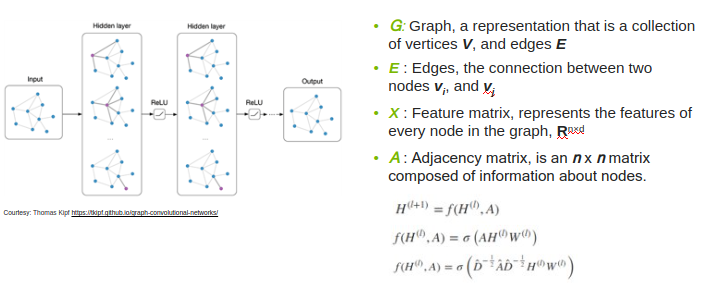

### 1. Install libraries

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Install DeepHyper/MetalgPy
!pip install -q deephyper["dev"]
!git clone https://github.com/deephyper/metalgpy.git
!cd metalgpy && git checkout develop && pip install -e .

# Install rdkit
!pip install -q rdkit-pypi

1.12.0+cu113
     |████████████████████████████████| 7.9 MB 12.1 MB/s 
     |████████████████████████████████| 3.5 MB 8.4 MB/s 
     |████████████████████████████████| 1.1 MB 8.8 MB/s 
     |████████████████████████████████| 4.7 MB 44.6 MB/s 
     |████████████████████████████████| 2.8 MB 35.8 MB/s 
     |████████████████████████████████| 6.5 MB 46.1 MB/s 
     |████████████████████████████████| 335 kB 50.2 MB/s 
     |████████████████████████████████| 181 kB 66.6 MB/s 
     |████████████████████████████████| 1.4 MB 57.1 MB/s 
     |████████████████████████████████| 3.3 MB 48.8 MB/s 
     |████████████████████████████████| 121 kB 58.8 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 90 kB 12.0 MB/s 
     |████████████████████████████████| 100 kB 12.5 MB/s 
     |████████████████████████████████| 548 kB 65.9 MB/s 
     |████████████████████████████████| 843 kB 62.8 MB/s 
     |████████████████████████████████| 96 kB 7.6 MB/s 
     |██

## Molecular property prediction

-------------------
`MoleculeNet`: A benchmark dataset comprised of datasets from diverse domains such as Quantum Mechanics, Physical Chemistry, Biophysics, and Physiology. The datasets are Non-Euclidean and serve as a good examples for employing Graph Neural Networks (GNN's) for molecular property prediction.

--------------------

`ESOL` data set contains information about structures and water solubility. It is composed of water solubility data(log solubility in mols per litre) for organic molecules. The encoded SMILES strings in the data set are used to estimate water solubility directly from molecular structures. ESOL has 1128 compounds in total and one target variable. It consists of :

*   Log-scale water solubility of the compound

-----------------------

`FreeSolv` data set is part of the Free Solvation Database. It is composed of information about the measured, and calculated hydration free energy of small molecules in water. FreeSolv has 628 compounds in total and one target variable. It consists of :

* Measured solvation energy (unit: kcal/mol) of the compound.
* Calculated solvation energy (unit: kcal/mol) of the compound.

-------------------------
Lipophilicity data set is built from the ChEMBL database. It is composed of the octanol/water distribution coefficient(logD at pH 7.4) for molecules. The data places emphasis on outlining the features that affect the membrane permeability and solubility of drug molecules. Lipophilicity has 4200 compounds in total and one target variable. It consists of :
* Measured octanol/water distribution coefficient *logD* of the compound.

---------------------------

### Mini Batch multiple smaller graphs into a bigger graph

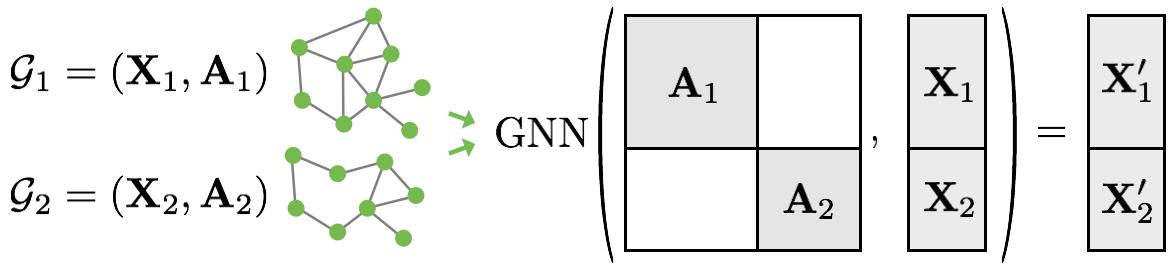

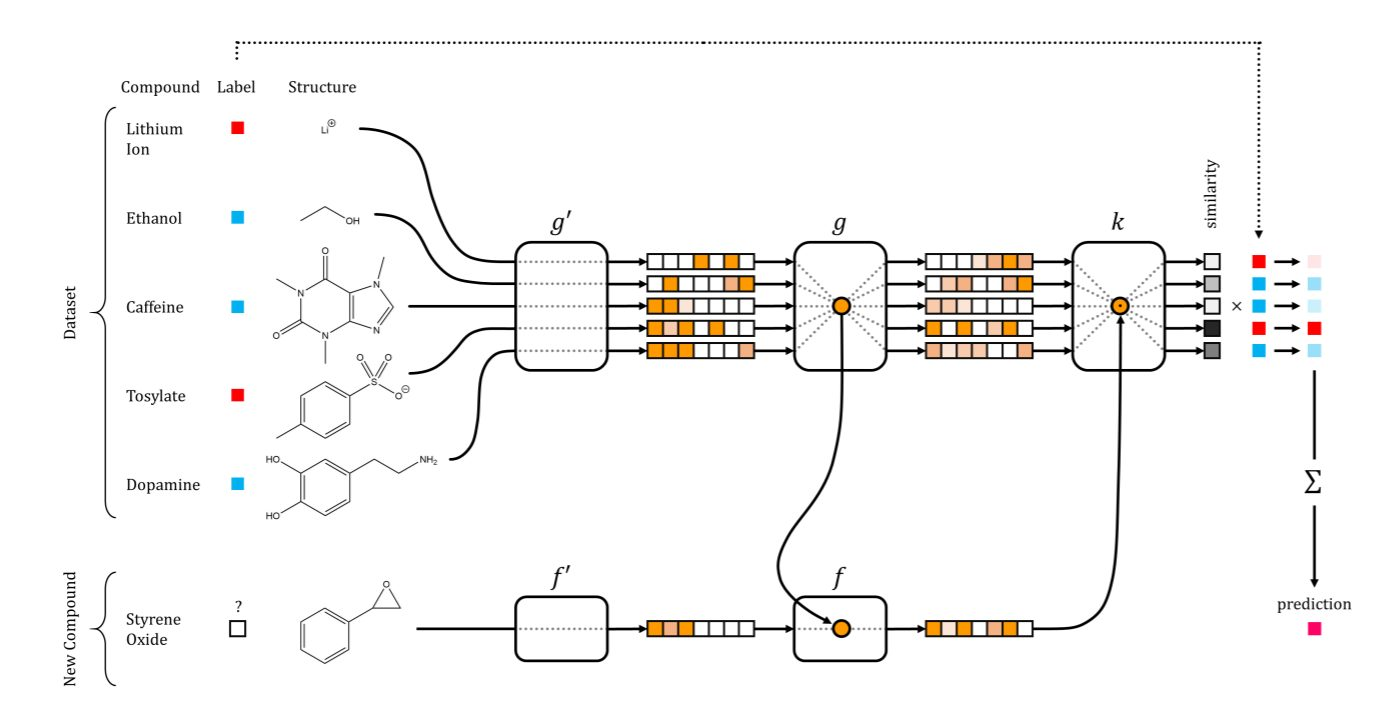

Courtesy: https://www.datasciencecentral.com/profiles/blogs/when-not-to-use-deep-learning

### Import the libraries

In [ ]:
%cd metalgpy

/content/metalgpy


In [ ]:
# This Source Code Form is subject to the terms of the
# BSD 2-Clause "Simplified" License. If a copy of the same 
# was not distributed with this file, You can obtain one at
# https://github.com/deephyper/metalgpy/blob/master/LICENSE.

import os, sys
sys.path.append(os.getcwd())
import timeit
import torch
import numpy as np
import metalgpy as mpy
import torch_geometric as pyg
from typing import Callable
from collections import defaultdict
from sklearn.metrics import *

# check if CUDA exists
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Load the FreeSolv data

In [ ]:
# define the helper method to load dataset
def load_molnet_graph_data(name, batch_size, training_split, seed=2022):
    """
    Load the specific Graph dataset from MoleculeNet
    Parameters
    ----------
    arg1 | name: str
        Name of the dataset to import from Pytorch Geometric MoleculeNet dataloader.
    arg2 | batch_size: int
        Batch size for creating the train/test dataloaders.
    arg3 | training_split: float
        Percentage of samples to be kept in training set.
    arg4 | seed: int
        Torch Random seed to ensure reproducibility. Default value is 2022
    Returns
    -------
    Pytorch Geometric Dataset(s)
        torch_geometric.datasets.molecule_net.MoleculeNet
    """
    # load the dataset
    dataset = pyg.datasets.MoleculeNet(root='/tmp/Molnet', name=name)

    # set the seed
    torch.manual_seed(seed)

    # shuffle the data
    dataset = dataset.shuffle()

    # set an stop index for gathering train data
    stop_index = int(np.floor(training_split*dataset.len()))

    # separate training data
    train_dataset = dataset[0:stop_index]

    # separate test data
    test_dataset = dataset[stop_index:]

    # create dataloaders for train and test samples
    train_loader = pyg.loader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = pyg.loader.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return dataset, train_loader, test_loader

In [ ]:
# load the freesolv data
dataset, train_loader, test_loader = load_molnet_graph_data("FreeSolv", 64, 0.8)

# set the input node features
NUM_NODE_FEATURES = dataset.num_node_features

# set the edge features
NUM_EDGE_FEATURES = dataset.num_edge_features

# set the output channels
NUM_OUT_FEATURES = list(dataset)[0].y.shape[0]

# print the data
print(dataset)

FreeSolv(642)


### Build a simple Message Passing model

In [ ]:
# define the MPNN class
@mpy.meta
class MPNN_mpy(torch.nn.Module):
    """
    Creates an MPNN model in pytorch geometric
    """
    def __init__(
            self,
            n_node_features: int,
            n_edge_features: int,
            n_hidden: int,
            n_output: int,
            MPNN_inp: torch.nn.Module,
            MPNN_hidden: torch.nn.Module,
            n_conv_blocks: int,
            skip_connection: str="plain") -> None:
        """
        Build the MPNN model
        Parameters
        ----------
        arg1 | n_node_features: int
            Number of features at node level
        arg2 | n_edge_features: int
            Number of features at edge level
        arg3 | n_hidden: int
            Number of hidden activations
        arg4 | n_output: int
            Number of output activations
        arg5 | n_conv_blocks: int
            Number of convolutional kernels
        Returns
        -------
        Nothing
            None
        """
        # super class the class structure
        super().__init__()
        
        # set the growth dimension
        self.growth_dimension = n_hidden

        # encode the node information
        self.node_encoder = MPNN_inp(n_node_features, n_hidden)

        # add the ability to add one or more conv layers
        conv_blocks = []

        # ability to add one or more conv blocks
        for block in range(n_conv_blocks):
            if skip_connection == "dense":
                self.growth_dimension = n_hidden + (n_hidden * block)
            conv = MPNN_hidden(self.growth_dimension, n_hidden)
            norm = torch.nn.LayerNorm(n_hidden, elementwise_affine=True)
            act = torch.nn.ReLU(inplace=True)
            layer = pyg.nn.DeepGCNLayer(conv, norm, act, block=skip_connection)
            conv_blocks.append(layer)

        # group all the conv layers
        self.conv_layers = torch.nn.ModuleList(conv_blocks)

        # add the linear layers for flattening the output from MPNN
        self.flatten = torch.nn.Sequential(
            torch.nn.Linear(self.growth_dimension, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_output))
        
    def forward(self,
                x: torch.Tensor,
                edge_index: torch.Tensor,
                batch_idx: torch.Tensor) -> torch.Tensor:
        """
        Process the MPNN model
        Parameters
        ----------
        arg1 | x: torch.Tensor
            Input features at node level
        arg2 | edge_index: torch.Tensor
            Index pairs of verticies
        arg3 | batch_idx: torch.Tensor
            Batch index
        Returns
        -------
        Tensor
            torch.Tensor
        """
        # obtaint the input
        if isinstance(self.node_encoder, pyg.nn.MessagePassing):
            x = self.node_encoder(x, edge_index)
        else:
            x = self.node_encoder(x)

        # pass the node information to the conv layer
        x = self.conv_layers[0].conv(x, edge_index)

        # process the layers
        for layer in range(len(self.conv_layers[1:])):
            x = self.conv_layers[layer](x, edge_index)

        # obtain the output from the MPNN final layer
        y = pyg.nn.global_add_pool(x, batch=batch_idx)

        # pass the output to the linear output layer
        out = self.flatten(y)

        # return the output
        return out

### Train and evaluate the simple model

In [ ]:
# define the helper method to train
def model_train(
        model: torch.nn.Module,
        dataloader: pyg.loader.DataLoader,
        learning_rate: float,
        ITERATIONS: int,
        optimizer: torch.optim.Optimizer,
        compute_loss: Callable,
        logging=False) -> torch.nn.Module:
    """
    Train the Pytorch Geometric model and return
    the model
    Parameters
    ----------
    arg1 | model: torch.nn.Module
        Trained Neural network model
    arg2 | dataloader: DataLoader
        Dataset as a DataLoader object
    arg3 | model: float
        Trained Neural network model
    arg4 | dataloader: int
        Dataset as a DataLoader object
    arg5 | model: torch.optim.Optimizer
        Trained Neural network model
    arg6 | dataloader: DataLoader
        Dataset as a DataLoader object
    Returns
    -------
    Pytorch model
        torch.nn.Module
    """
    for iteration in range(ITERATIONS):
        # set the model for training
        model.train()

        # iterate in batches over the training dataset
        for data in dataloader:
            # set the gradients to zero
            optimizer.zero_grad()

            # forward pass and compute the y hat values
            y_hat = model(data.x.float().to(device),
                          data.edge_index.long().to(device),
                          data.batch.long().to(device))

            # compute the mean squared error loss
            cost = compute_loss(y_hat, data.y.to(device))

            # compute mse loss again for the backward pass
            cost.backward()

            # update the weights
            optimizer.step()

        # display the stats
        if logging:
            print(f'Epoch: {iteration:03d}, Loss: {cost:.4f}')

    # return the tuple [Ground truth, Predictions]
    return model

# define the helper method to evaluate
def model_evaluate(
        model: torch.nn.Module,
        dataloader: pyg.loader.DataLoader,
) -> (torch.Tensor, torch.Tensor):
    """
    Evaluate the Pytorch model and return
    ground truth along with predictions
    Parameters
    ----------
    arg1 | model: torch.nn.Module
        Trained Neural network model
    arg2 | dataloader: DataLoader
        Dataset as a DataLoader object
    """
    # init an empty list to capture y hats
    y_preds = []

    # init an empty list to capture ground truth
    y_true = []

    # set the model to evaluate
    model.eval()

    # Iterate in batches over the test dataset.
    for data in test_loader:
        # store the ground truth
        y_true.append(data.y)

        # gather the model prediction
        out = model(data.x.float().to(device),
                    data.edge_index.long().to(device),
                    data.batch.long().to(device))

        # store the model predictions
        y_preds.append(torch.flatten(out, start_dim=1))

    # concat the predictions obtained in batches
    y_preds = torch.cat(y_preds)

    # concat the ground truth obtained in batches
    y_true = torch.cat(y_true)

    # return the tuple [Ground truth, Predictions]
    return (y_true, y_preds)

# define the helper method to obtain evaluation metrics
def regression_evaluation_metrics(
        y_true: torch.Tensor,
        y_preds: torch.Tensor,
        metric: str
) -> None:
    """
    Print the Pytorch model metrics based
    on the ground truth vs predictions
    Parameters
    ----------
    arg1 | y_true: torch.Tensor
        Ground truth values of the data
    arg2 | y_preds: torch.Tensor
        Model Predictions for the input data
    """
    # init an empty dict to store results
    results = defaultdict(dict)

    # store y_preds and y_true as numpy arrays
    y_true = y_true.detach().numpy()
    y_preds = y_preds.cpu().detach().numpy()

    # MSE
    results['mse'] = mean_squared_error(y_true, y_preds)

    # MAE
    results['mae'] = mean_absolute_error(y_true, y_preds)

    # RMSE
    results['rmse'] = mean_squared_error(y_true, y_preds, squared=False)

    # R2
    results['r2'] = r2_score(y_true, y_preds)

    # return appropriate metric(s)
    if metric == "all":
        return results
    if metric in results.keys():
        return results[metric]
    else:
        return defaultdict(dict)

In [ ]:
n_inp_channels = NUM_NODE_FEATURES
n_out_channels = 1
Linear = mpy.meta(torch.nn.Linear)
GCNConv = mpy.meta(pyg.nn.GCNConv) 
SAGEConv = mpy.meta(pyg.nn.SAGEConv)
GATConv = mpy.meta(pyg.nn.GATConv)
max_layers = 5

model = MPNN_mpy(
    n_node_features=n_inp_channels,
    n_edge_features=0,
    n_hidden=mpy.Int(64, 1024, name="n_hidden"),
    n_output=n_out_channels,
    MPNN_inp=mpy.List([Linear, GCNConv, SAGEConv, GATConv], name="mpnn_inp"),
    MPNN_hidden=mpy.List([GCNConv, SAGEConv, GATConv], name="mpnn_hidden"),
    n_conv_blocks=mpy.Int(1, 10, name="n_conv_blocks"),
    skip_connection=mpy.List(["res", "dense", "plain"], ordered=False, name="skip_conn_choice")
)

model

MPNN_mpy(n_node_features=9, n_edge_features=0, n_hidden=Int(id=n_hidden, low=64, high=1024), n_output=1, MPNN_inp=List(id=mpnn_inp, [<class 'torch.nn.modules.linear.Linear'>, <class 'torch_geometric.nn.conv.gcn_conv.GCNConv'>, <class 'torch_geometric.nn.conv.sage_conv.SAGEConv'>, <class 'torch_geometric.nn.conv.gat_conv.GATConv'>]), MPNN_hidden=List(id=mpnn_hidden, [<class 'torch_geometric.nn.conv.gcn_conv.GCNConv'>, <class 'torch_geometric.nn.conv.sage_conv.SAGEConv'>, <class 'torch_geometric.nn.conv.gat_conv.GATConv'>]), n_conv_blocks=Int(id=n_conv_blocks, low=1, high=10), skip_connection=List(id=skip_conn_choice, ['res', 'dense', 'plain']))

In [ ]:
# get a random number for seed
seed = np.random.randint(0, 9999)

# print the seed
print("Seed:", seed)

# use the seed to set the random state
rng = np.random.RandomState(seed)

# init the basesampler object
model_sampler = mpy.sampler.RandomSampler(model, rng=rng)

# init the optimizer object
opt = mpy.optimizer.BayesianOptimizer(model_sampler, random_state=rng)

# sample three sample configurations
sample_pyg_model_config = model_sampler.sample(30, False)

# print an example config
print("-----------------")
print("Example PyG model config: \n", sample_pyg_model_config[-1])
print("-----------------")

Seed: 4401
-----------------
Example PyG model config: 
 {'mpnn_hidden': 1, 'mpnn_inp': 1, 'n_conv_blocks': 5, 'n_hidden': 81, 'skip_conn_choice': 2}
-----------------


In [ ]:
# set the loss function for training
loss_fn = torch.nn.MSELoss()

# set the learning rate for the function
lr = 1e-3

# set number of epochs
EPOCHS = 1000

# iters
iters = 10

In [ ]:
# store the results in a list
results = []

# iterate over a batch of samples for 'n' iterations
for iteration in range(iters):
    # fetch the config space from the optimizer
    x = opt.ask()
    
    # convert the following space to a dictionary
    x_dict = {k:v for k, v in zip(model.variables().keys(), x)}
    
    # display the model config
    print("-----------------")
    print(x_dict)
    print("-----------------\n")
    
    # obtain the frozen model expression (PyTorch model)
    frozen_model = model.clone().freeze(x_dict)
    
    # evaluate the frozen model
    eval_model = frozen_model.evaluate()
    
    # records the time at this instant of the program
    train_time_start = timeit.default_timer()
    
    # train the model
    eval_model = model_train(eval_model.to(device), \
                                train_loader, \
                                lr, \
                                EPOCHS, \
                               torch.optim.Adam(eval_model.parameters(), lr = lr),\
                               loss_fn, logging=False)
    
    # records the time at this instant of the program
    train_time_end = timeit.default_timer()
    
    # store the value
    model_train_time = train_time_end-train_time_start
    
    # obtain the predictions
    y_true, y_preds = model_evaluate(eval_model.to(device), test_loader)
    
    # obtain the evaluation metrics
    y = regression_evaluation_metrics(y_true, y_preds, 'rmse')
    model_eval_results = regression_evaluation_metrics(y_true, y_preds, 'all')

    # report the model
    opt.tell(x, y, fit=True)

    # store the results
    results.append((x, y, model_eval_results, model_train_time))
    
    # display the stats
    print(f'ITER: {iteration:03d}, Objective: {y:.4f}\n')

-----------------
{'mpnn_hidden': 0, 'mpnn_inp': 0, 'n_conv_blocks': 8, 'n_hidden': 667, 'skip_conn_choice': 2}
-----------------

ITER: 000, Objective: 3.7943

-----------------
{'mpnn_hidden': 1, 'mpnn_inp': 3, 'n_conv_blocks': 3, 'n_hidden': 739, 'skip_conn_choice': 2}
-----------------

ITER: 001, Objective: 1.8867

-----------------
{'mpnn_hidden': 0, 'mpnn_inp': 2, 'n_conv_blocks': 9, 'n_hidden': 735, 'skip_conn_choice': 1}
-----------------

ITER: 002, Objective: 2.4987

-----------------
{'mpnn_hidden': 2, 'mpnn_inp': 3, 'n_conv_blocks': 2, 'n_hidden': 893, 'skip_conn_choice': 0}
-----------------

ITER: 003, Objective: 1.9268

-----------------
{'mpnn_hidden': 2, 'mpnn_inp': 0, 'n_conv_blocks': 2, 'n_hidden': 733, 'skip_conn_choice': 0}
-----------------

ITER: 004, Objective: 3.3121

-----------------
{'mpnn_hidden': 2, 'mpnn_inp': 2, 'n_conv_blocks': 8, 'n_hidden': 712, 'skip_conn_choice': 2}
-----------------

ITER: 005, Objective: 3.8093

-----------------
{'mpnn_hidden': 